# Условие задачи

Вам необходимо построить модель, которая на основании данных, поступающих каждую минуту, определяют качество продукции, производимое на обжиговой машине.

Обжиговая машина представляет собой агрегат, состоящий из 5 одинаковых по размеру камер, в каждой камере установлено по 3 датчика температур. Кроме этого, для данной задачи Вы собрали данные о высоте слоя сырья и его влажности. Высота слоя и влажность измеряются при входе сырья в машину. Сырье проходит через обжиговую машину за час.

Данные с показателями работы обжиговой машины содержатся в файле X_data.csv

Качество продукции измеряется в лаборатории по пробам, которые забираются каждый час, данные по известным анализам содержатся в файле Y_train.csv. В файле указано время забора пробы, проба забирается на выходе из обжиговой машины.

Вы договорились с заказчиком, что оценкой модели будет являться показатель MAE, для оценки модели необходимо сгенерировать предсказания за период, указанный в файле Y_submit.csv (5808 предиктов).

Более подробно задача описана в репозитории https://github.com/slgero/testovoe

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [14]:
# импорт данных
data = pd.read_csv('X_data.csv', sep=';')
y_train = pd.read_csv('Y_train.csv', sep=';', header=None)
y_test = pd.read_csv('Y_submit.csv', sep=';', header=None)

# Чистка данных и первичный анализ

In [15]:
# поправим названия колонок
data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
y_train.rename(columns={0: 'Date', 1: 'Quality'}, inplace=True)
y_test.rename(columns={0: 'Date', 1: 'Quality'}, inplace=True)

In [16]:
data.head()

,Date,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


Оценка качества происходит через час после попадания образца в печь - соответственно для каждой строчки в X_data нужно определить время, когда соответствующий образец будет на выходе их печи. После этого можно объединять X и Y датафреймы для дальшейшего анализа.

In [17]:
# сначала сконвертим все колонки с датами в соответствующий тип
data['Date'] = pd.to_datetime(data['Date'])
y_train['Date'] = pd.to_datetime(y_train['Date'])
y_test['Date'] = pd.to_datetime(y_test['Date'])

In [18]:
# для data вычислим время, когда каждый образец выйдет из печи (добавим везде час)
data['Date_out'] = data['Date'] + pd.DateOffset(hours=1)

In [19]:
# теперь хотим посмотреть на уникальные значения в каждом Y сете, их пересечения между собой и с данными в data
Y_train_unique_dates = set(y_train.Date.values)
Y_test_unique_dates = set(y_test.Date.values)
print(f'В фрейме y_train {len(Y_train_unique_dates)} уникальных записей по времени из {len(y_train.Date.values)} записей')
print(f'В фрейме y_test {len(Y_test_unique_dates)} уникальных записей по времени из {len(y_test.Date.values)} записей')
data_unique_dates = set(data.Date_out.values)
data_y_train_intersection = data_unique_dates.intersection(Y_train_unique_dates)
data_y_test_intersection = data_unique_dates.intersection(Y_test_unique_dates)
y_train_y_test_intersection = Y_train_unique_dates.intersection(Y_test_unique_dates)
print(f'В фрейме data {len(data_y_train_intersection)} записей совпадают по времени с y_train (из {len(Y_train_unique_dates)} записей y_train)')
print(f'В фрейме data {len(data_y_test_intersection)} записей совпадают по времени с y_test (из {len(Y_test_unique_dates)} записей y_test)')
print(f'В фрейме y_train {len(y_train_y_test_intersection)} записей совпадают по времени с y_test (из {len(Y_test_unique_dates)} записей y_test)')

В фрейме y_train 29184 уникальных записей по времени из 29184 записей
В фрейме y_test 5808 уникальных записей по времени из 5808 записей
В фрейме data 29184 записей совпадают по времени с y_train (из 29184 записей y_train)
В фрейме data 5808 записей совпадают по времени с y_test (из 5808 записей y_test)
В фрейме y_train 0 записей совпадают по времени с y_test (из 5808 записей y_test)


Видим, что в трейне и сплите все записи уникальные, и между ними нет пересечений - уже хорошо, не нужно никаких дополнительных действий

In [21]:
# собираем в трейне только те данные из data, которые совпадают по date_out
train_data = data[(data['Date_out'].isin(y_train['Date']))]
train_data = pd.merge(train_data, y_train, left_on='Date_out', right_on='Date').drop(columns=['Date_y'])
train_data.rename(columns={'Date_x': 'Date_in'}, inplace=True)

In [23]:
train_data.head()

,Date_in,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,Date_out,Quality
0,2015-01-03 23:05:00,266,339,263,335,326,341,495,497,535,316,346,336,234,238,239,154.87,4.73,2015-01-04 00:05:00,392
1,2015-01-04 00:05:00,277,326,273,322,335,352,505,501,670,326,379,337,231,236,242,153.77,7.90,2015-01-04 01:05:00,384
2,2015-01-04 01:05:00,277,253,272,320,333,355,500,501,687,337,396,335,234,242,230,158.27,6.96,2015-01-04 02:05:00,393
3,2015-01-04 02:05:00,262,218,260,326,336,330,505,499,443,347,399,332,243,251,240,153.36,7.29,2015-01-04 03:05:00,399
4,2015-01-04 03:05:00,243,238,252,327,329,308,520,498,540,342,387,334,257,258,246,153.21,7.11,2015-01-04 04:05:00,400


Text(0.5, 0, 'Качество продукции. ед')

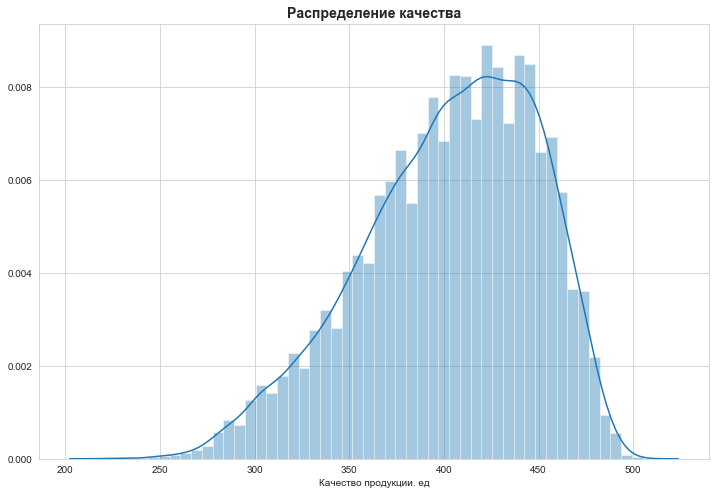

In [39]:
# посмотрим на распределение качества
fig, ax = plt.subplots(figsize=(12,8))
fig = sns.distplot(train_data['Quality'])
fig.set_title('Распределение качества', fontsize=14, fontweight='bold')
fig.set_xlabel('Качество продукции. ед')

In [41]:
train_data['Quality'].describe()

count    29184.000000
mean       402.800747
std         46.273228
min        221.000000
25%        372.000000
50%        408.000000
75%        439.000000
max        505.000000
Name: Quality, dtype: float64

По заданию непонятно, в чем измеряется качество, и какая оценка считается хорошей. Предположим, меньше 372 (первый квартиль) - плохое качество; от 372 до 439 (значения в пределах интерквантильного размаха)- нормальное. И больше 439 - экстра-качество. Разделим по этому правилу и построим парные диаграммы.

In [44]:
train_data['QType'] = pd.cut(x=train_data['Quality'],
                             bins=[train_data['Quality'].min(),
                                   train_data['Quality'].quantile(.25),
                                   train_data['Quality'].quantile(.75),
                                   train_data['Quality'].max()],
                             labels=['poor', 'normal', 'extra'],
                             include_lowest=True)

In [45]:
train_data.head()

,Date_in,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,...,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,Date_out,Quality,QType
0,2015-01-03 23:05:00,266,339,263,335,326,341,495,497,535,...,346,336,234,238,239,154.87,4.73,2015-01-04 00:05:00,392,normal
1,2015-01-04 00:05:00,277,326,273,322,335,352,505,501,670,...,379,337,231,236,242,153.77,7.90,2015-01-04 01:05:00,384,normal
2,2015-01-04 01:05:00,277,253,272,320,333,355,500,501,687,...,396,335,234,242,230,158.27,6.96,2015-01-04 02:05:00,393,normal
3,2015-01-04 02:05:00,262,218,260,326,336,330,505,499,443,...,399,332,243,251,240,153.36,7.29,2015-01-04 03:05:00,399,normal
4,2015-01-04 03:05:00,243,238,252,327,329,308,520,498,540,...,387,334,257,258,246,153.21,7.11,2015-01-04 04:05:00,400,normal


# Бейзлайн модель

Про процесс известно очень мало, для начала можно проверить гипотезу о том, что качество зависит от высоты слоя породы (H_data) и влажности (AH_data) на входе. Забьем пока на всю температуру и построим диаграммы только для этих двух фич и качества

<function matplotlib.pyplot.legend(*args, **kwargs)>

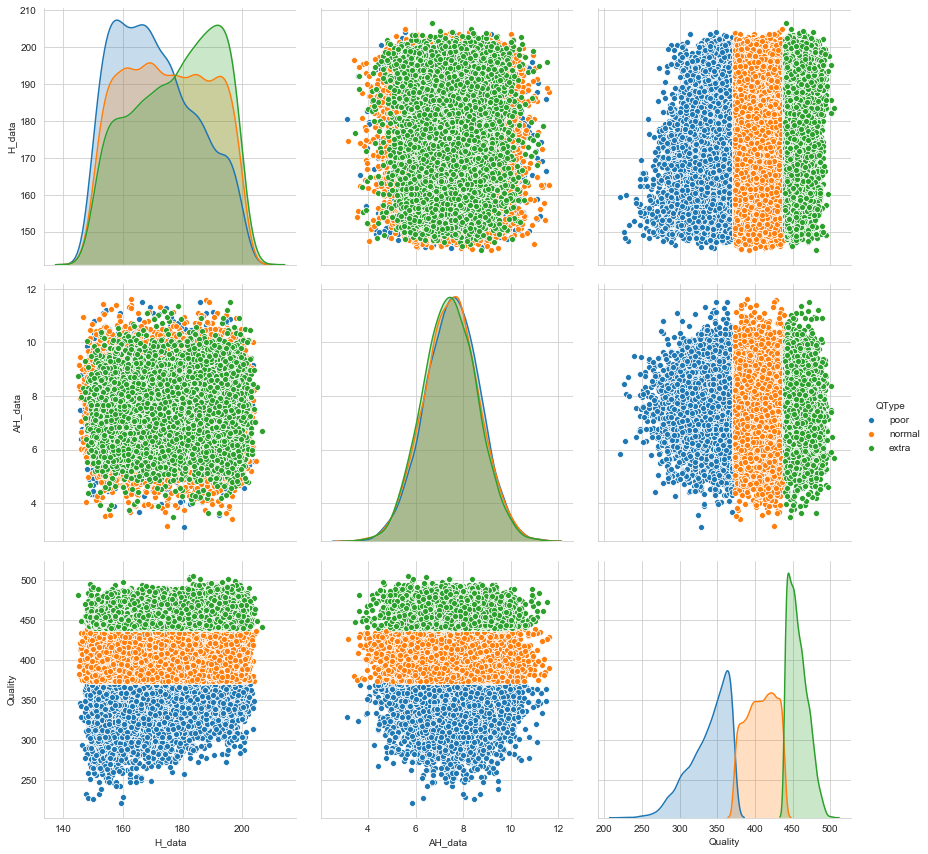

In [59]:
pairplot_df = train_data[['H_data', 'AH_data', 'Quality', 'QType']]
fig = sns.pairplot(data=pairplot_df, hue='QType', height = 4)

Видно вопиющее отсутствие корреляции качества от толщины слоя и влажности (с учетом того, что не совсем понятно, какое качество хорошее - может быть так и должно быть). Тем не менее попробуем построить простейшую модель на этих двух фичах.

In [60]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from xgboost import XGBRegressor

In [76]:
Features = train_data[['H_data', 'AH_data']]
Target = train_data['Quality']
random_seed = 42

In [77]:
base_model = XGBRegressor(random_state = random_seed)
mae = make_scorer(mean_absolute_error)

In [78]:
base_score = cross_val_score(base_model, Features, Target, scoring=mae, cv=5)

[19:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [79]:
# Получили бейзлайн
print(f'Mean score is {base_score.mean()} ± {base_score.std()}')

Mean score is 37.27205082051015 ± 0.706718390279036


In [67]:
train_data['Quality'].median()

408.0

Итак, по кроссвалидации модель в среднем ошибается на 37 единиц при медианной оценке качества в 408 единиц. Это 9 % - для простой модели наверное неплохо, но посмотрим, что можно еще выжать из этого всего. Сначала попробуем подкрутить параметры у этой модели - считается она достаточно быстро, поэтому можно запустить гридсерч сразу на трех важных параметрах.

In [69]:
# прогоним гридсерч
base_model_params = {'n_estimators': range(1,100,1),
               'max_depth': range(1,5,1),
               'learning_rate': np.arange(0.1,0.01, -0.02)
              }
base_model_gsearch = GridSearchCV(estimator = base_model, 
                        param_grid = base_model_params,
                        scoring='neg_mean_absolute_error',
                        n_jobs=4, iid=False, cv=5, verbose=1)

In [72]:
base_model_gsearch.fit(Features, Target)
base_model_gsearch.best_params_, base_model_gsearch.best_score_

Fitting 5 folds for each of 1980 candidates, totalling 9900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 902 tasks      | elapsed:   49.9s
[Parallel(n_jobs=4)]: Done 1364 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1930 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 3140 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 4378 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 5736 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done 7402 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done 9380 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 9900 out of 9900 | elapsed: 10.6min finished


[19:12:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 93},
 -37.22211720342718)

Видно, что тюнинг никак не помог этой модели, значит можно добавить новых фичей

# Усложняем модель - добавление температурных фичей

In [85]:
# втупую
Features = train_data.drop(columns=['Quality', 'QType', 'Date_in', 'Date_out'])
Target = train_data['Quality']
random_seed = 42

In [86]:
full_feature_model = XGBRegressor(random_state = random_seed)

In [87]:
full_feature_score = cross_val_score(full_feature_model, Features, Target, scoring=mae, cv=5)

[19:45:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [88]:
# Получили бейзлайн
print(f'Mean score is {full_feature_score.mean()} ± {full_feature_score.std()}')

Mean score is 10.079030051846292 ± 0.27814547406083107


Видим, что модель значительно улучшилась - это уже всего 2 % от медианной оценки

In [89]:
# прогоним гридсерч
full_feature_model_params = {'n_estimators': range(1,100,1),
               'max_depth': range(1,5,1),
               'learning_rate': np.arange(0.1,0.01, -0.02)
              }
full_feature_model_gsearch = GridSearchCV(estimator = base_model, 
                        param_grid = full_feature_model_params,
                        scoring='neg_mean_absolute_error',
                        n_jobs=4, iid=False, cv=5, verbose=1)

In [90]:
full_feature_model_gsearch.fit(Features, Target)
full_feature_model_gsearch.best_params_, full_feature_model_gsearch.best_score_

Fitting 5 folds for each of 1980 candidates, totalling 9900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   43.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 12.7min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 14.7min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 18.7min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 21.2min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 25.5min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 29.7min
[Parallel(n_jobs=4)]: Done 9900 out of 9900 | elapsed: 30.6mi

[20:24:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 99},
 -9.772413285914878)

Стандартный тюнинг ненамного улучшает ситуацию. Можно еще покрутить параметры, но лучше, пожалуй, покрутить фичи - взять среднюю температуру в камере, изменение температуры в течение часа, и тд, посмотреть какие фичи добавляют только шум.